In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lime
import shap
import os
import sys

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, f1_score, roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [91]:
data_path = os.path.dirname(os.getcwd()) + "\_datasets"
df = pd.read_csv(data_path + "\delaney.csv")
df

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


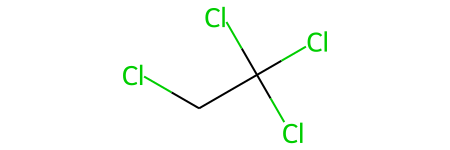

In [92]:
Chem.MolFromSmiles(df['SMILES'][0])

In [93]:
Chem.MolFromSmiles(df['SMILES'][0]).GetNumAtoms()

6

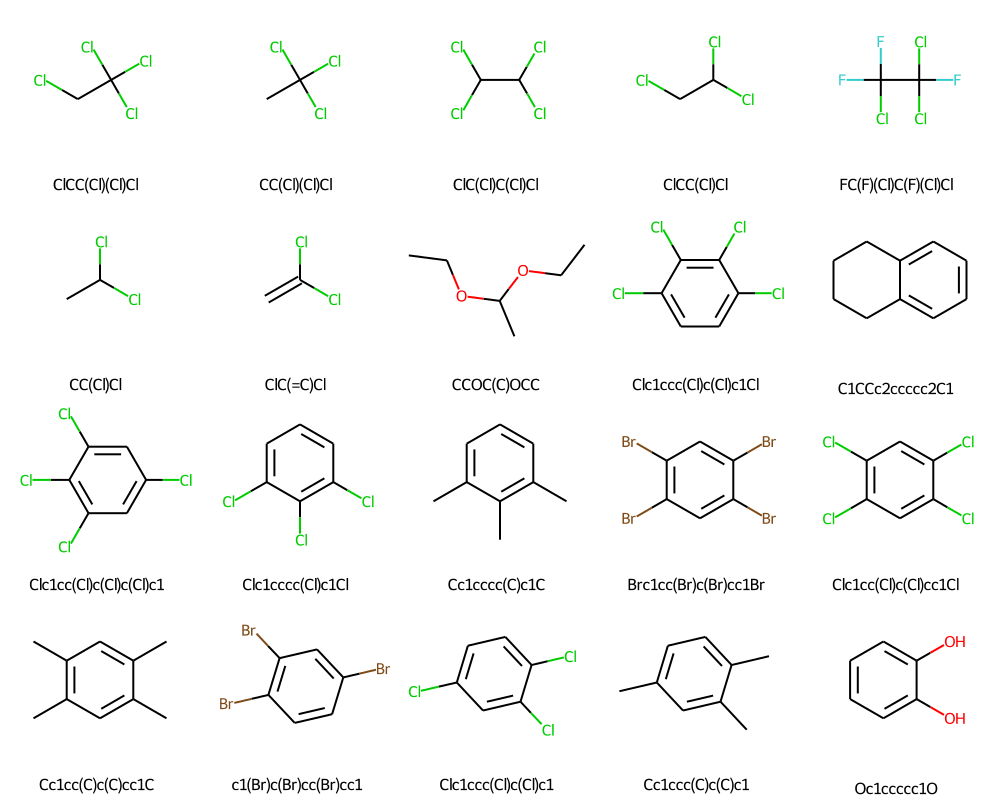

In [94]:
df['mol'] = df['SMILES'].apply(lambda x: Chem.MolFromSmiles(x)) 
mols = df['mol'][:20]
Chem.Draw.MolsToGridImage(mols, molsPerRow=5, useSVG=True, legends=list(df['SMILES'][:20].values))

In [95]:
df['mol'] = df['mol'].apply(lambda x: Chem.AddHs(x))
df['n_atoms'] = df['mol'].apply(lambda x: x.GetNumAtoms())
df['n_h_atoms'] = df['mol'].apply(lambda x: x.GetNumHeavyAtoms())
df['logp'] = df['mol'].apply(lambda x: Chem.Descriptors.MolLogP(x))
df['mol_weight'] = df['mol'].apply(lambda x: Chem.Descriptors.MolWt(x))
df['rot_bonds'] = df['mol'].apply(lambda x: Chem.Descriptors.NumRotatableBonds(x))
df['arom_prop'] = df['mol'].apply(lambda x: len(list(x.GetAromaticAtoms())) / x.GetNumHeavyAtoms())

In [96]:
y = df.iloc[:,1]
X = df.drop(df.columns[1], 1)
X = X.drop(['Compound ID', 'SMILES', 'mol'], 1)

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


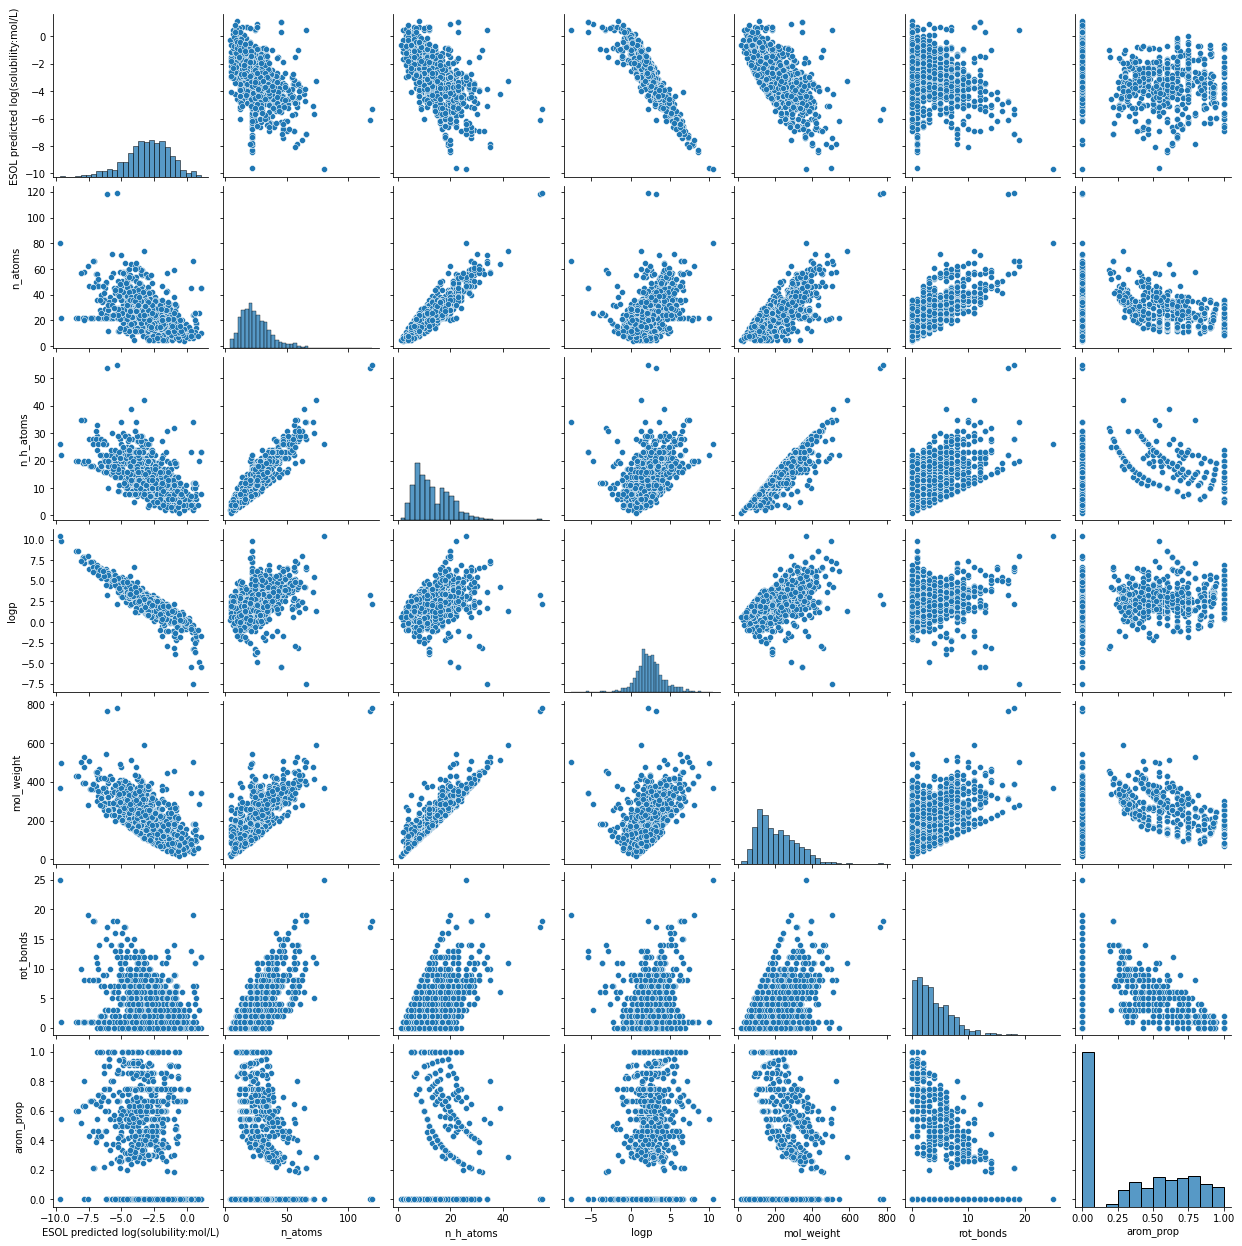

In [101]:
sns.pairplot(X)

In [98]:
def results_kfold(X, y, regression=True):

    result_dict = {}
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    
    reg_columns = ['RMSE', 'MAE', 'R2']
    clf_columns = ['F1', 'PRECIS', 'RECALL', 'ROC AUC', 'T POS', 'F POS', 'F NEG', 'T NEG']
            
    if regression:

        for name,regressor in regressors:

            rmse = []
            mae = []
            r2 = []

            for train_index, test_index in cv.split(X):
                X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
                score = regressor.fit(X_train, y_train)
                prediction = score.predict(X_test)

                rmse.append(np.sqrt(mean_squared_error(y_test, prediction)))
                mae.append(mean_absolute_error(y_test, prediction))
                r2.append(score.score(X_train, y_train))

            if name not in result_dict:
                result_dict[name] = []

            result_dict[name].append(np.mean(rmse))
            result_dict[name].append(np.mean(mae))
            result_dict[name].append(np.mean(r2))
               
        result_dict = pd.DataFrame.from_dict(result_dict, orient='index')
        result_dict.columns = reg_columns
            
    else:
        
        for name,classifier in classifiers:

            f1 = []
            precis = []
            recall = []
            roc_auc = []
            t_pos = []
            f_pos = []
            f_neg = []
            t_neg = []

            for train_index, test_index in cv.split(X):
                X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
                score = classifier.fit(X_train, y_train)
                prediction = score.predict(X_test)
                
                p_r_f1 = precision_recall_fscore_support(y_test, prediction, average='weighted')
                precis.append(p_r_f1[0])
                recall.append(p_r_f1[1])
                f1.append(p_r_f1[2])
                roc_auc.append(roc_auc_score(y_test, prediction))
          
                cm = confusion_matrix(y_test, prediction)
                t_pos.append(cm[0][0])
                f_pos.append(cm[0][1])
                f_neg.append(cm[1][0])
                t_neg.append(cm[1][1])

            if name not in result_dict:
                result_dict[name] = []

            result_dict[name].append(np.mean(f1))
            result_dict[name].append(np.mean(precis))
            result_dict[name].append(np.mean(recall))
            result_dict[name].append(np.mean(roc_auc))
            result_dict[name].append(np.mean(t_pos))
            result_dict[name].append(np.mean(f_pos))
            result_dict[name].append(np.mean(f_neg))
            result_dict[name].append(np.mean(t_neg))
            
        result_dict = pd.DataFrame.from_dict(result_dict, orient='index')
        result_dict.columns = clf_columns

    return result_dict

In [99]:
regressors = [['DecisionTreeRegressor :', DecisionTreeRegressor()],
              ['RandomForestRegressor :', RandomForestRegressor()],
              ['ExtraTreesRegressor :', ExtraTreesRegressor()],
              ['GradientBoostingRegressor :', GradientBoostingRegressor()],
              ['XGBRegressor :', XGBRegressor()]]

In [100]:
results = results_kfold(X, y, regression=True)
results

,RMSE,MAE,R2
DecisionTreeRegressor :,0.850842,0.601648,0.996957
RandomForestRegressor :,0.654272,0.469117,0.983746
ExtraTreesRegressor :,0.640671,0.452075,0.996957
GradientBoostingRegressor :,0.660007,0.495425,0.945073
XGBRegressor :,0.660128,0.474820,0.996108
